In [11]:
from matplotlib import animation, patches
from IPython.display import display_html
from matplotlib import pyplot as plt
from itertools import product
from math import sin, cos
from tqdm import tqdm
import pandas as pd
import numpy as np
from z3 import *

pd.options.display.float_format = '{:,.2f}'.format
%config InlineBackend.figure_format = "svg"
%matplotlib notebook

### Constantes globais

In [2]:
V_LOW, V_HIGH = 1, 10 # velocidades dos modos baixo e alto, em m
THETA = 15 # angulo de viragem entre modos
TAU = 10 # tempo minimo entre transicoes timed
ALL_ROUTES = [i*THETA for i in range(int(360/THETA))] # todos os ângulos possíveis
ALL_VELS = [V_LOW, V_HIGH] # todas as velocidades possiveis

GAUSS_DP = 80 # desvio padrão da gaussiana de inicialização das posições em m
SAFE_DIST = 100 # distância de segurança entre barcos em m

Mode, (M_LOW, M_HIGH) = EnumSort("Mode", ("V_LOW", "V_HIGH"))

### Funções auxiliares

In [3]:
deg_to_rad = lambda a: a * np.pi / 180
rad_to_deg = lambda a: a * 180 / np.pi
z3tofloat = lambda v: float(v.numerator_as_long())/float(v.denominator_as_long())
Abs = lambda x: If(x>=0, x, -x)
val_angle = lambda a: If(a<0, 360+a, If(a>=360, a-360, a))
vel_to_mode = lambda v: M_LOW if (v == V_LOW) else M_HIGH
mode_to_vel = lambda m: V_LOW if (m == M_LOW) else V_HIGH

In [4]:
def model_to_dfs(m):
    m_ = {str(elem): m[elem] for elem in m}
    sortedkeys = sorted(m_, key=str.lower)

    prop_names = sorted(list(set([str(elem)[:-1] for elem in sortedkeys])))
    df_dict = {p: [] for p in prop_names}

    for col in df_dict:
        for elem in sortedkeys:
            if col in elem:
                if m_[elem].sort() == RealSort():
                    value = z3tofloat(m_[elem])
                else:
                    value = m_[elem]
                df_dict[col].append(value)

    df_dict = {i: {elem: df_dict[elem] for elem in df_dict if f"b{i}" in elem} for i in range(3)}

    dfs = [pd.DataFrame(df_dict[i]) for i in range(len(df_dict))]
        
    return dfs
    
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Funções de declaração, inicialização e transição

In [5]:
def declare(t, fixed_dist=None, num_boats=3):
    # Iterar os barcos
    trace = {}
    for i in range(num_boats):
        trace[i] = {}
        
        # Variáveis de modo
        trace[i]["v"] = Const(f"b{i}_v{t}", Mode)
        trace[i]["a"] = Int(f"b{i}_a{t}")
        
        # Variáveis de estado
        trace[i]["x"] = Real(f"b{i}_x{t}")
        trace[i]["y"] = Real(f"b{i}_y{t}")
        trace[i]["t"] = Real(f"b{i}_t{t}")
        
        # Flag de transicao
        trace[i]["f"] = Bool(f"b{i}_f{t}")
        
    # Distancia de seguranca
    if fixed_dist == None:
        trace["d"] = Int(f"d{t}")
    else:
        trace["d"] = fixed_dist
        
    return trace
        
        
def init(tr):
    # Gerar ângulos iniciais aleatórios
    random_angles = ALL_ROUTES
    
    # Iterar os barcos
    r = []
    for i in range(len(tr)-1):
        np.random.shuffle(random_angles)
        
        # Condições do modo VERIFICACAO MODO VELOCIDADE INIT
        r.append(tr[i]["v"] == M_HIGH)
        # r.append(tr[i]["a"] == random_angles[0])
        r.append(tr[i]["a"] == int((210 + 120*i)%360))
        
        # Condições do estado
        # r.append(tr[i]["x"] == GAUSS_DP * np.random.randn())
        # r.append(tr[i]["y"] == GAUSS_DP * np.random.randn())
        r.append(tr[i]["x"] == 60 * cos(deg_to_rad(30 + 120*i)))
        r.append(tr[i]["y"] == 60 * sin(deg_to_rad(30 + 120*i)))
        r.append(tr[i]["t"] == 0)
        
        # Condicao da flag
        r.append(tr[i]["f"] == False)
        
    # Condicao da distancia de seguranca
    if type(tr["d"]) != int:
        r.append(And(tr["d"] > 0, tr["d"] < 100))
        
    r = And(r)
    
    return r
        
    
def timed(prev, curr, fixed_step=False):
    modes = list(product(*[ALL_VELS, ALL_ROUTES]))
    
    # Iterar cada um dos barcos
    r = []
    for i in range(len(prev)-1):
        
        # Condição do tempo
        if fixed_step:
            r.append(curr[i]["t"] - prev[i]["t"] == TAU)
        else:
            r.append(curr[i]["t"] - prev[i]["t"] > TAU)
        
        # Condição da rota e posição
        routes_cond = []
        for j in range(len(modes)):
            route_cond = []
            
            # Condição dos modos
            v, a = modes[j]
            route_cond.append(And(prev[i]["a"] == a, prev[i]["v"] == vel_to_mode(v)))
            route_cond.append(And(curr[i]["a"] == a, curr[i]["v"] == vel_to_mode(v)))
            
            # Incremento de posição
            dx = v * cos(deg_to_rad(a)) * (curr[i]["t"] - prev[i]["t"])
            dy = v * sin(deg_to_rad(a)) * (curr[i]["t"] - prev[i]["t"])
            
            # Condição da posição
            route_cond.append(curr[i]["x"] == prev[i]["x"] + dx)
            route_cond.append(curr[i]["y"] == prev[i]["y"] + dy)
            
            # Fazer o And de todas as condições
            routes_cond.append(And(route_cond))
            
        # Caso esteja com V_HIGH e a uma distancia de perigo
        r.append(Not(And(prev[i]["v"] == M_HIGH, Not(switch_safe(prev, i)))))
        
        # Caso esteja com V_LOW e a uma distancia segura
        r.append(Not(And(prev[i]["v"] == M_LOW, switch_safe(prev, i))))
        
        # Adicionar uma de todas as rotas possíveis
        r.append(Or(routes_cond))
        
    r = And(r)
        
    return r


def switch_safe(tr, boat_id):
    r = []
    
    # Iterar cada um dos barcos
    for i in range(len(tr)-1):
        if i != boat_id:
            # Condição das distâncias
            x = Abs(tr[i]["x"]-tr[boat_id]["x"]) > tr["d"]
            y = Abs(tr[i]["y"]-tr[boat_id]["y"]) > tr["d"]
            
            t_conds = []
            all_vels = list(product(*[ALL_VELS, ALL_VELS]))
            for v1, v2 in all_vels:
                
                # Condição do tempo
                m1, m2 = vel_to_mode(v1), vel_to_mode(v2)
                t1 = And(m1 == tr[boat_id]["v"], m2 == tr[i]["v"])
                t2 = Abs(tr[i]["t"]-tr[boat_id]["t"])*(v1+v2)/2 > tr["d"]
                
                t_conds.append(And(t1, t2))
            
            t = Or(t_conds)
            
            # Verificar se uma das distâncias é superior à distância de segurança
            r.append(Or(x, y, t))
            
    r = And(r)
            
    return r


def untimed(prev, curr):
    r = []
    
    # Iterar cada um dos barcos
    for i in range(len(prev)-1):
        
        # Condições da posição e tempo
        r.append(curr[i]["x"] == prev[i]["x"])
        r.append(curr[i]["y"] == prev[i]["y"])
        r.append(curr[i]["t"] == prev[i]["t"])

        # barco V_LOW transita para V_LOW
        low_low = []
        low_low.append(And(prev[i]["v"] == M_LOW, curr[i]["v"] == M_LOW))
        low_low.append(Not(switch_safe(prev, i)))
        low_low.append(Or(curr[i]["a"] == val_angle(prev[i]["a"]+THETA), curr[i]["a"] == val_angle(prev[i]["a"]-THETA)))
        low_low = And(low_low)

        # barco V_LOW transita para barco V_HIGH
        low_high = []
        low_high.append(And(prev[i]["v"] == M_LOW, curr[i]["v"] == M_HIGH))
        low_high.append(switch_safe(prev, i))
        low_high.append(curr[i]["a"] == prev[i]["a"])
        low_high = And(low_high)

        # barco V_HIGH transita para barco V_LOW
        high_low = []
        high_low.append(And(prev[i]["v"] == M_HIGH, curr[i]["v"] == M_LOW))
        high_low.append(Not(switch_safe(prev, i)))
        high_low.append(Or(curr[i]["a"] == val_angle(prev[i]["a"]+THETA), curr[i]["a"] == val_angle(prev[i]["a"]-THETA)))
        high_low = And(high_low)

        # barco V_HIGH transita para barco V_HIGH
        high_high = []
        high_high.append(And(prev[i]["v"] == M_HIGH, curr[i]["v"] == M_HIGH))
        high_high.append(switch_safe(prev, i))
        high_high.append(curr[i]["a"] == prev[i]["a"])
        high_high = And(high_high)

        # Adicionar uma destas possíveis transições
        r.append(And(Or(low_low, low_high, high_low, high_high), Not(prev[i]["f"])))
        
    # O estado não pode ficar igual
    same = []
    for i in range(len(prev)-1):
        same.append(prev[i]["v"] == curr[i]["v"])
        same.append(prev[i]["a"] == curr[i]["a"])
        same.append(prev[i]["x"] == curr[i]["x"])
        same.append(prev[i]["y"] == curr[i]["y"])
    same = Not(And(same))

    # Todas as condições da transição devem ser cumpridas
    # r = And(And(r), same, timed(prev, curr))
    r = And(And(r), same)
    
    return r


def trans(prev, curr, fixed_step=False):
    # Condições timed e untimed
    untimed_cond = untimed(prev, curr)
    timed_cond = timed(prev, curr, fixed_step)
    
    # Condições de sincronismo
    eq_cond = And([curr[i]["t"] == curr[i+1]["t"] for i in range(len(curr)-2)])
    
    # Condicao da manutencao da distancia de seguranca
    d_cond = prev["d"] == curr["d"]
    
    # Condicao da evolucao da flag
    f_cond = []
    for i in range(len(prev)-1):
        v_cond = prev[i]["v"] != curr[i]["v"]
        a_cond = prev[i]["a"] != curr[i]["a"]
        f_cond.append(If(Or(v_cond, a_cond), curr[i]["f"], Not(curr[i]["f"])))
    f_cond = And(f_cond)
    
    r = And(Or(untimed_cond, timed_cond), eq_cond, d_cond, f_cond)
    
    return r

In [10]:
def gen_trace(declare, init, trans, k, fixed_step=False, fixed_dist=None):
    solver = Solver()
    trace = {i: declare(i, fixed_dist) for i in range(k)}
    solver.add(init(trace[0]))
    
    for i in range(k-1):
        solver.add(trans(trace[i], trace[i+1], fixed_step))
        
    if solver.check() == sat:
        m = solver.model()
        r = model_to_dfs(m)
        display_side_by_side(*r)
    else:
        r = None
        
    return r

m = gen_trace(declare, init, trans, 10, True, SAFE_DIST)

,b0_a,b0_f,b0_t,b0_v,b0_x,b0_y
0,210,False,0.00,V_HIGH,51.96,30.00
1,195,True,0.00,V_LOW,51.96,30.00
2,195,False,10.00,V_LOW,42.30,27.41
3,195,False,20.00,V_LOW,32.64,24.82
4,195,False,30.00,V_LOW,22.98,22.24
5,195,False,40.00,V_LOW,13.32,19.65
6,195,False,50.00,V_LOW,3.67,17.06
7,195,False,60.00,V_LOW,-5.99,14.47
8,180,True,60.00,V_LOW,-5.99,14.47
9,180,False,70.00,V_LOW,-15.99,14.47


In [7]:
trace = {i: declare(i, SAFE_DIST) for i in range(1)}
solver = Solver()
solver.add(init(trace[0]))
solver.add(switch_safe(trace[0], 0))

if solver.check() == sat:
    m = solver.model()
    r = model_to_dfs(m)
    display_side_by_side(*r)

<IPython.core.display.Javascript object>


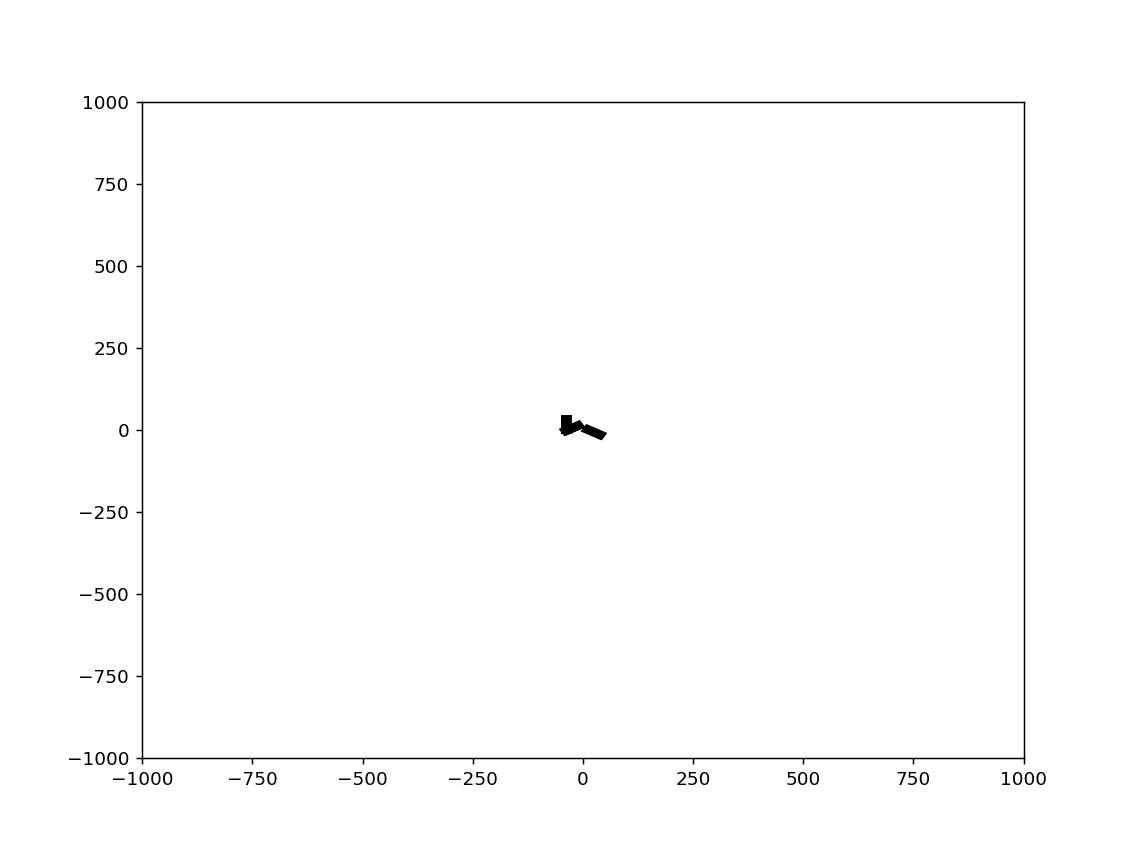

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.axis("off")
plt.rcParams["animation.html"] = "jshtml"

plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)

RB = []
for i in range(len(m)):
    RB.append(patches.Rectangle((m[i][f"b{i}_x"][0],m[i][f"b{i}_y"][0]), 50, 20, angle=str(m[i][f"b{i}_a"][0]), color="black"))

def init_anim():
    for i in range(len(m)):
        ax.add_patch(RB[i])
    return RB

def animate(i):
    for j in range(len(m)):
        x, y = m[j][f"b{j}_x"][i], m[j][f"b{j}_y"][i]
        RB[j].set_x(x)
        RB[j].set_y(y)
        RB[j]._angle = deg_to_rad(m[j][f"b{j}_a"][i])
    
    return RB

anim = animation.FuncAnimation(fig, animate, 
                           init_func=init_anim, 
                           frames=len(m[0]), 
                           interval=1000,
                           blit=True)

plt.show()